The point of this exercise was not to make sure everything works flawlessly but was a way for me to familiarize myself with Tensorflow. It would probably take quite a bit more time to iron out all the rough edges, to tune hyperparameters, etc. But I am not sure that spending time on this makes sense for me at this point. So please proceed with caution.

Some of the obvious things that are missing are not recalculating batch norm statistics during inference and training with weight decay. It would also be nice to use gradient clipping, test time augmentation and implement running loss.

Having said this, this still achieves 92% accuracy on the validation set after ~20 epochs of training, which is quite decent.

I am sharing this as I still feel it can be helpful. There are not many self contained examples of Tensorflow code available on the Internet that would not center on using estimators or keras (or at least I had a lot of trouble finding them) and in particular the documentation on how to use TFRecord files seems to be rather sparse.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import multiprocessing
from glob import glob
from __future__ import division

import tensorflow as tf
from models import resnet_model # this is slightly modified from the original
import numpy as np
import cv2

In [2]:
resnet_size = 18
num_classes = 10
resnet_version = 2
data_format = 'channels_first'
num_blocks = 4

In [3]:
m = resnet_model.Model(resnet_size=resnet_size,
        bottleneck=False,
        num_classes=num_classes,
        num_filters=[16, 160, 320, 640],
        kernel_size=3,
        conv_stride=1,
        first_pool_size=None,
        first_pool_stride=None,
        block_sizes=[num_blocks] * 3,
        block_strides=[1, 2, 2],
        final_size=320,
        resnet_version=resnet_version,
        data_format=data_format)

In [4]:
PATH = '../data/cifar10/'

In [5]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# per channel means and st_devs
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

##  Create TFRecord files

http://machinelearninguru.com/deep_learning/data_preparation/tfrecord/tfrecord.html#create

In [6]:
trn_paths = glob(PATH + 'train/**/*')
val_paths = glob(PATH + 'test/**/*')
np.random.shuffle(trn_paths)
np.random.shuffle(val_paths)

In [7]:
n = 10
trn_paths_with_targets = [(trn_paths[i::n], PATH + 'train_{}_of_10.tfrecords'.format(i+1)) for i in range(n)]
val_paths_with_targets = [(val_paths[i::n], PATH + 'val_{}_of_10.tfrecords'.format(i+1)) for i in range(n)]

In [8]:
def tfrecords_from_paths(paths, save_to):
    with tf.python_io.TFRecordWriter(save_to) as w:
        ims = []
        for path in paths:
            im = cv2.imread(path)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            cls = path.split('/')[-2]
            cls_idx = classes.index(cls)

            feature = {
                'cls': tf.train.Feature(
                    bytes_list=tf.train.BytesList(
                        value=[tf.compat.as_bytes(cls)]
                    )
                ),
                'cls_idx': tf.train.Feature(
                    int64_list=tf.train.Int64List(
                        value=[cls_idx]
                    )
                ),
                'im': tf.train.Feature(
                    bytes_list=tf.train.BytesList(
                        value=[tf.compat.as_bytes(im.astype(np.float32).tostring())]
                    )
                )
            }
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            w.write(example.SerializeToString())

In [9]:
%%time
pool = multiprocessing.Pool(processes=10)
pool.starmap(tfrecords_from_paths, trn_paths_with_targets)
pool.starmap(tfrecords_from_paths, val_paths_with_targets)

CPU times: user 32 ms, sys: 52 ms, total: 84 ms
Wall time: 1.39 s


## Contruct the Datest pipepline

In [10]:
bs = 128

In [11]:
def parse_record(record):
    features = {
        'cls': tf.FixedLenFeature([], tf.string),
        'cls_idx': tf.FixedLenFeature([], tf.int64),
        'im': tf.FixedLenFeature([], tf.string)
    }
    example = tf.parse_single_example(record, features)
    example['im'] = tf.decode_raw(example['im'], out_type=tf.float32)
    example['im'] = tf.reshape(example['im'], (32, 32, 3))
    return example

In [12]:
tf_stats = tf.constant(np.stack(stats).astype(np.float32))
def augment_im(ex):
    ex['im'] = tf.pad(ex['im'], [(4, 4), (4, 4), (0, 0)])
    ex['im'] = tf.random_crop(ex['im'], (32, 32, 3))
    
    ex['im'] = tf.cond(
        tf.greater(tf.random_uniform([]), 0.5),
        lambda: tf.image.flip_left_right(ex['im']), 
        lambda: ex['im'])
    
    # normalizing the image
    ex['im'] /= 255
    ex['im'] -= tf_stats[0]
    ex['im'] /= tf_stats[1]
    return ex

In [13]:
train_fns = tf.data.Dataset.list_files(PATH + 'train*.tfrecords')
trn_ds = tf.data.TFRecordDataset(train_fns) \
    .shuffle(1000) \
    .map(parse_record) \
    .map(augment_im) \
    .batch(bs) \
    .repeat()

In [14]:
val_fns = tf.data.Dataset.list_files(PATH + 'val*.tfrecords')
val_ds = tf.data.TFRecordDataset(val_fns) \
    .map(parse_record) \
    .batch(5000)

In [15]:
def get_lr(batch_num, total_batches, max_lr, lr_ratio, last_phase_duration):
    starting_lr = max_lr / lr_ratio
    final_lr = starting_lr / 100
    main_cycle_duration = total_batches - (total_batches / 100) * last_phase_duration
    single_phase_duration = main_cycle_duration / 2
    last_phase_duration = total_batches - main_cycle_duration
    if batch_num <= single_phase_duration:
        return starting_lr + (batch_num / single_phase_duration) * (max_lr - starting_lr)
    elif batch_num <= main_cycle_duration:
        return max_lr - ((batch_num - single_phase_duration) / single_phase_duration) * (max_lr - starting_lr)
    else:
        return starting_lr - (batch_num - main_cycle_duration) * (starting_lr - final_lr) / last_phase_duration

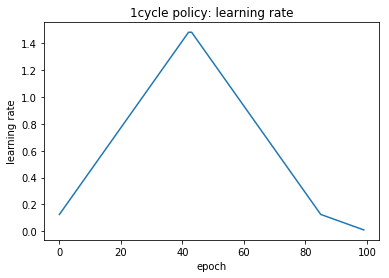

In [16]:
plt.plot([get_lr(i, 100, 1.5, 12, 15) for i in range(100)])
plt.title('1cycle policy: learning rate')
plt.xlabel('epoch')
plt.ylabel('learning rate');

In [17]:
def get_mom(batch_num, total_batches, last_phase_duration, max_mom=0.95, min_mom=0.85):
    main_cycle_duration = int(total_batches - (total_batches / 100) * last_phase_duration)
    single_phase_duration = main_cycle_duration / 2
    last_phase_duration = total_batches - main_cycle_duration
    if batch_num <= single_phase_duration:
        return max_mom - (max_mom - min_mom) * batch_num / single_phase_duration
    elif batch_num <= main_cycle_duration:
        return min_mom + (max_mom - min_mom) * (batch_num - single_phase_duration) / single_phase_duration
    else:
        return max_mom

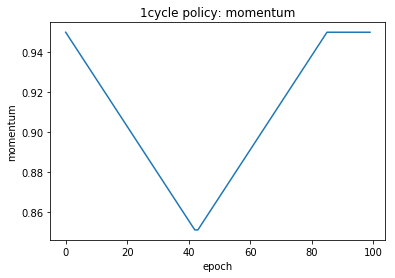

In [18]:
plt.plot([get_mom(i, 100, 15) for i in range(100)])
plt.title('1cycle policy: momentum')
plt.xlabel('epoch')
plt.ylabel('momentum');

In [19]:
training_duration = 15000 # num of batches to train on, around 17 epochs
max_lr = 1.5

In [20]:
%%time

train_graph = tf.Graph()
with train_graph.as_default():
    batch = trn_ds.make_one_shot_iterator().get_next()

    logits = m(batch['im'], True)
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(batch['cls_idx'], logits)
    accuracy = tf.metrics.accuracy(batch['cls_idx'], tf.argmax(logits, 1))

    learning_rate = tf.placeholder(tf.float32, shape=[])
    momentum = tf.placeholder(tf.float32, shape=[])
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    
    global_step = tf.train.get_or_create_global_step()
    minimize_op = optimizer.minimize(cross_entropy, global_step)

    saver = tf.train.Saver()

    with tf.Session() as s:
        s.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
        while True:
            step = s.run([global_step])[0]
            lr, mom = get_lr(step, training_duration, max_lr, 12, 15), get_mom(step, training_duration, 15)
            _, loss = s.run([minimize_op, cross_entropy], feed_dict={learning_rate: lr, momentum: mom})

            if step % 750 == 0:
                print(step, loss, s.run([accuracy][0][1]))
            if step == training_duration - 1:
                print(step, loss, s.run([accuracy][0][1]))
                saver.save(s, '/root/workspace/model.ckpt')
                break

0 2.3851616 0.171875
2250 0.5101474 0.60546875
3000 0.60501933 0.665625
3750 0.3608644 0.7057292
4500 0.340433 0.73883927
5250 0.335846 0.7636719
6000 0.26189458 0.7838542
6750 0.28541684 0.8
7500 0.23169807 0.81392044
8250 0.15814932 0.8255208
9000 0.08956765 0.8359375
9750 0.11746195 0.8448661
10500 0.15202297 0.8541667
11250 0.03559986 0.86279297
12000 0.02826716 0.8699449
12750 0.010788053 0.87717015
13500 0.0043187393 0.88363487
14250 0.0022717537 0.8894531
14999 0.0019251698 0.8947173
CPU times: user 30min 37s, sys: 7min 27s, total: 38min 5s
Wall time: 26min 9s


In [21]:
val_graph = tf.Graph()
with val_graph.as_default():
    batch = val_ds.make_one_shot_iterator().get_next()

    logits = m(batch['im'], True)
    accuracy = tf.metrics.accuracy(batch['cls_idx'], tf.argmax(logits, 1))
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(batch['cls_idx'], logits)
    
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    saver = tf.train.Saver()
    with tf.Session() as s:
        s.run([init_op])
        saver.restore(s, '/root/workspace/model.ckpt')
        loss, acc = s.run([cross_entropy, accuracy])
        print('val_loss: ', loss, 'val accuracy: ', acc[1], sep='\t')

INFO:tensorflow:Restoring parameters from /root/workspace/model.ckpt
val_loss: 	0.38016033	val accuracy: 	0.9224
